In [ ]:
# CSV 파일 불러오기
# for vs code
file_path1 = 'data/Meteorological_2019_01.csv'
file_path2 = 'data/서울시_대기질_2019_01.csv'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# CSV 파일 불러오기
# for google colab
file_path1 = '/content/drive/MyDrive/2024-2학기_연구참여/data/Meteorological_2019_01.csv'
file_path2 = '/content/drive/MyDrive/2024-2학기_연구참여/data/서울시_대기질_2019_01.csv'

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Conv3D, MaxPooling3D
from sklearn.model_selection import train_test_split

In [4]:
# 'Meteorological data' 측정 지역의 위도와 경도 정보
met_regions_data = {
    'region': ['강남', '서초', '강동', '송파', '강서', '양천', '도봉', '노원', '동대문', '중랑', '기상청', '마포', '서대문', '광진',
               '성북', '용산', '은평', '금천', '한강', '중구', '성동', '구로', '강북*', '남현', '관악', '영등포', '현충원'],
    'latitude': [37.49794, 37.47650, 37.53010, 37.51456, 37.55095, 37.51656, 37.66877, 37.65526, 37.57491, 37.59508, 37.56556,
                 37.56632, 37.57655, 37.53865, 37.58968, 37.53110, 37.60277, 37.45686, 37.52770, 37.56382, 37.56351, 37.49543,
                 37.646995, 37.46769, 37.47808, 37.52667, 37.50001],
    'longitude': [127.02761, 127.03250, 127.12587, 127.10662, 126.84953, 126.86658, 127.04744, 127.07712, 127.03963, 127.09368, 126.96691,
                  126.90131, 126.93784, 127.08237, 127.01667, 126.97960, 126.93040, 126.89576, 126.99818, 126.99760, 127.03722, 126.88740,
                  127.01371, 126.95818, 126.95143, 126.89636, 126.97422]
}

# DataFrame 생성
met_regions_df = pd.DataFrame(met_regions_data)

# '서울시 대기질 데이터' 각 구의 위도와 경도 정보
air_regions_data = {
    'region': ['종로구', '용산구', '중구', '은평구', '서대문구', '마포구', '광진구', '노원구', '중랑구', '도봉구',
               '성북구', '성동구', '강북구', '동대문구', '동작구', '영등포구', '강서구', '관악구', '양천구', '구로구',
               '금천구', '강남구', '서초구', '강동구', '송파구'],
    'latitude': [37.573050, 37.531100, 37.563820, 37.602770, 37.576550, 37.566320, 37.538650, 37.655260, 37.595080, 37.668770,
                 37.589680, 37.563510, 37.646995, 37.574910, 37.512410, 37.526670, 37.550950, 37.478080, 37.516560, 37.495430,
                 37.456860, 37.497940, 37.476500, 37.530100, 37.514560],
    'longitude': [126.979340, 126.979600, 126.997600, 126.930400, 126.937840, 126.901310, 127.082370, 127.077120, 127.093680, 127.047440,
                  127.016670, 127.037220, 127.013710, 127.039630, 126.941040, 126.896360, 126.849530, 126.951430, 126.866580, 126.887400,
                  126.895760, 127.027610, 127.032500, 127.125870, 127.106620]
}

# DataFrame 생성
air_regions_df = pd.DataFrame(air_regions_data)

In [5]:
# 전처리1: CSV 파일 특정 column만 불러오기
def read_processing(f1, f2):
    df1 = pd.read_csv(f1, usecols=lambda column: column != '지점', encoding='cp949')
    df2 = pd.read_csv(f2, usecols = ['측정일시', '측정소명', '오존(ppm)'], encoding='cp949')
    df2 = df2[['측정소명', '측정일시', '오존(ppm)']]
    return df1, df2

# 전처리2: 날짜 및 시간 데이터 변형
def time_processing(df1, df2):
    # df1의 '일시' 컬럼을 datetime 형식으로 변환
    df1['일시'] = pd.to_datetime(df1['일시'])

    # df2의 '측정일시' 컬럼을 datetime 형식으로 변환
    df2['측정일시'] = pd.to_datetime(df2['측정일시'], format='%Y%m%d%H%M')

    # df2를 정렬 (인플레이스)
    df2.sort_values(by=['측정소명', '측정일시'], inplace=True)

    # 인덱스 재설정 (인플레이스)
    df2.reset_index(drop=True, inplace=True)


In [6]:
# ------------------------------------------------------------------
# 전처리3: 누락된 부분 interpolation
# ------------------------------------------------------------------
def interpol_processing(df):
    expected_timesteps = 744

    # '지점명'별로 그룹화하여 '일시' 개수 세기
    grouped = df.groupby('지점명')['일시'].count()

    # 누락된 데이터 찾기
    missing_data = grouped[grouped < expected_timesteps]

    missing_rows_info = []

    for station in missing_data.index:
        station_data = df[df['지점명'] == station]

        # 전체 일시 범위 정의
        full_range = pd.date_range(start='2019-01-01 00:00', end='2019-01-31 23:00', freq='h')

        # 누락된 일시 찾기
        missing_dates = full_range.difference(station_data['일시'])

        for missing_date in missing_dates:
            missing_rows_info.append({'지점명': station, '일시': missing_date})

    # 누락된 데이터 복구를 위한 새로운 행 생성
    new_rows = []
    for missing_row in missing_rows_info:
        location = missing_row['지점명']
        date = missing_row['일시']
        temp_data = df[(df['지점명'] != location) & (df['일시'] == date)]
        tmp = temp_data['기온(°C)'].mean()

        new_rows.append({'지점명': location, '일시': date, '기온(°C)': tmp})

    # 모든 새로운 행을 한 번에 추가하여 복사 최소화
    if new_rows:
        df_new = pd.DataFrame(new_rows)
        df = pd.concat([df, df_new], ignore_index=True)

    # df를 정렬 (인플레이스)
    df.sort_values(by=['지점명', '일시'], inplace=True)
    df.reset_index(drop=True, inplace=True)

    return df

In [7]:
# 전처리4:'일시'를 '날짜'와 '시각'으로 분리
def t_split_processing(df1, df2):
    # df1의 '일시'를 '날짜'와 '시각'으로 분리
    df1['날짜'] = df1['일시'].dt.date
    df1['시각'] = df1['일시'].dt.time
    df1.drop(columns=['일시'], inplace=True)

    # df1의 컬럼 순서 재정렬
    df1 = df1[['지점명', '날짜', '시각', '기온(°C)']]

    # df2의 '측정일시'를 '날짜'와 '시각'으로 분리
    df2['날짜'] = df2['측정일시'].dt.date
    df2['시각'] = df2['측정일시'].dt.time
    df2.drop(columns=['측정일시'], inplace=True)

    # df2의 컬럼 순서 재정렬
    df2 = df2[['측정소명', '날짜', '시각', '오존(ppm)']]

In [13]:
# 전처리5: 매핑

# 각 위도와 경도를 그리드 좌표로 변환하는 함수
def latlon_to_grid(lat, lon, lat_min, lat_max, lon_min, lon_max, grid_size):
    # 위도와 경도를 32x32 그리드 좌표로 변환
    row = int((lat - lat_min) / (lat_max - lat_min) * (grid_size - 1))
    col = int((lon - lon_min) / (lon_max - lon_min) * (grid_size - 1))
    return row, col

def map_processing(df1, df2, grid_data, label_grid_data, time_stamp):
    # 서울시의 위도와 경도 범위 설정
    seoul_lat_min, seoul_lat_max = 37.4133, 37.7151  # 남북 경계 위도
    seoul_lon_min, seoul_lon_max = 126.7341, 127.2693  # 동서 경계 경도

    grid_size = 32
    time_size = 3
    n_day = len(df1['일시'].unique())

    # 기상 데이터 그리드 좌표 변환
    regions = met_regions_df['region'].unique()
    dates = df1['일시'].unique()

    for region in regions:
        lat = met_regions_df.loc[met_regions_df['region'] == region, 'latitude'].values[0]
        lon = met_regions_df.loc[met_regions_df['region'] == region, 'longitude'].values[0]
        grid_row, grid_col = latlon_to_grid(lat, lon, seoul_lat_min, seoul_lat_max, seoul_lon_min, seoul_lon_max, grid_size)
        met_sub_data = df1.loc[df1['지점명'] == region]

        # 시각별 데이터 할당
        # 0번째 시각
        grid_data[0, 0, grid_row, grid_col, 0] = met_sub_data.iloc[0]['기온(°C)']
        grid_data[0, 1, grid_row, grid_col, 0] = met_sub_data.iloc[0]['기온(°C)']
        grid_data[0, 2, grid_row, grid_col, 0] = met_sub_data.iloc[0]['기온(°C)']
        # 1번째 시각
        grid_data[1, 0, grid_row, grid_col, 0] = met_sub_data.iloc[0]['기온(°C)']
        grid_data[1, 1, grid_row, grid_col, 0] = met_sub_data.iloc[1]['기온(°C)']
        grid_data[1, 2, grid_row, grid_col, 0] = met_sub_data.iloc[1]['기온(°C)']
        # 2번째 시각
        grid_data[2, 0, grid_row, grid_col, 0] = met_sub_data.iloc[0]['기온(°C)']
        grid_data[2, 1, grid_row, grid_col, 0] = met_sub_data.iloc[1]['기온(°C)']
        grid_data[2, 2, grid_row, grid_col, 0] = met_sub_data.iloc[2]['기온(°C)']

        #3번째~n_day-1까지 시각
        for date_index, date in enumerate(dates):
            if(date_index == n_day - time_size):
                break
            i_data = date_index+time_size # 3개의 시간대로 1개의 시간예측
            grid_data[i_data, 0:time_size, grid_row, grid_col, 0] = met_sub_data.iloc[date_index:date_index+time_size]['기온(°C)']


    # 오염물질 농도 매핑
    label_regions = air_regions_df['region'].unique()
    label_dates = df2['측정일시'].unique()

    for region in label_regions:
        lat = air_regions_df.loc[air_regions_df['region'] == region, 'latitude'].values[0]
        lon = air_regions_df.loc[air_regions_df['region'] == region, 'longitude'].values[0]
        l_grid_row, l_grid_col = latlon_to_grid(lat, lon, seoul_lat_min, seoul_lat_max, seoul_lon_min, seoul_lon_max, grid_size)
        air_sub_data = df2.loc[df2['측정소명']==region]

        # 시각별 데이터 할당
        for date_index, date in enumerate(label_dates):
            i_data = date_index
            label_grid_data[i_data, 0, l_grid_row, l_grid_col, 0] = air_sub_data.iloc[date_index]['오존(ppm)']
            time_stamp[i_data] = date # 현재 기록되는 오존값이 어느 시점의 오존 값인지 기록


In [14]:
for i in range(1, 2):
    # 변수 초기화
    time_size = 3
    grid_size = 32
    grid_data = np.zeros((744, time_size, grid_size, grid_size, 1))
    label_grid_data = np.zeros((744, 1, grid_size, grid_size, 1))
    time_stamp = np.empty(744, dtype='datetime64[m]')
    # file_path1 = f'data/Meteorological_20{i+18}_01.csv'
    # file_path2 = f'data/서울시_대기질_20{i+18}_01.csv'

    # Data PreProcessing
    met_data, air_quality_data = read_processing(file_path1, file_path2)
    time_processing(met_data, air_quality_data)
    met_data = interpol_processing(met_data)
    # t_split_processing(met_data, air_quality_data)
    map_processing(met_data, air_quality_data, grid_data, label_grid_data, time_stamp)
    X = grid_data
    Y = label_grid_data

In [11]:
# 모델 적용
tf.random.set_seed(1234)

# 모델 생성
model = Sequential([
    Conv3D(32, kernel_size = (2,3,3), activation='relu', input_shape=(time_size,grid_size,grid_size,1)),
    MaxPooling3D(pool_size = (1,2,2)),
    Conv3D(64, kernel_size = (2,3,3), activation='relu'),
    MaxPooling3D(pool_size = (1,2,2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(32*32, activation = 'linear')
])

# 모델 컴파일
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 데이터 변환
Y = Y.reshape(Y.shape[0], -1)

# 모델 학습
model.fit(X, Y, epochs=10, batch_size = 16, validation_split=0.2)

# 모델 평가
loss = model.evaluate(X,Y)
print(f"Loss: {loss}")


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 162ms/step - loss: 0.0017 - mae: 0.0133 - val_loss: 5.3208e-06 - val_mae: 0.0014
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 123ms/step - loss: 3.6921e-06 - mae: 9.4315e-04 - val_loss: 2.5767e-06 - val_mae: 3.5657e-04
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - loss: 2.4252e-06 - mae: 3.0007e-04 - val_loss: 2.5543e-06 - val_mae: 2.4142e-04
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - loss: 2.4026e-06 - mae: 2.2113e-04 - val_loss: 2.5408e-06 - val_mae: 2.2447e-04
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 6s 166ms/step - loss: 2.4045e-06 - mae: 2.1044e-04 - val_loss: 2.5302e-06 - val_mae: 2.2186e-04
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 2.4064e-06 - mae: 2.0911e-04 - val_loss: 2.5196e-06 - val_mae: 2.2122e-04
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 2.4082e-06 - mae: 2.0912e-04 - val_loss: 2.5095e-06 - val_mae: 2.2086e-04
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - loss: 2.4099e-06 - m

In [12]:
# 모델 사용
Ozone_predict = model.predict(X)
Ozone_predict = Ozone_predict.reshape(-1, 32, 32)

print(Ozone_predict)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
(744, 1024)
[[[-1.5516295e-11  1.5420217e-13  3.4991313e-12 ...  1.6224629e-11
    1.9070119e-11  3.0656238e-11]
  [ 4.1198340e-11 -4.4071313e-12  1.8544454e-11 ...  8.8451997e-12
   -2.6324498e-12 -1.1048591e-11]
  [-2.0931276e-11  4.4612931e-11  1.1870691e-11 ... -7.6746214e-12
   -1.1631612e-11 -1.5429262e-11]
  ...
  [ 1.8749115e-11  2.5782497e-12 -3.4637020e-12 ... -6.8953272e-12
   -3.3998464e-12  2.3397671e-11]
  [-9.6510092e-12 -6.1347052e-11  4.8822240e-12 ... -5.9825221e-11
    1.3059206e-11  1.6428558e-11]
  [-2.1393318e-11  5.1802230e-12  3.9027892e-11 ... -5.2224535e-12
   -1.4822065e-11  2.3383547e-11]]

 [[-1.5516295e-11  1.5420217e-13  3.4991313e-12 ...  1.6224629e-11
    1.9070119e-11  3.0656238e-11]
  [ 4.1198340e-11 -4.4071313e-12  1.8544454e-11 ...  8.8451997e-12
   -2.6324498e-12 -1.1048591e-11]
  [-2.0931276e-11  4.4612931e-11  1.1870691e-11 ... -7.6746214e-12
   -1.1631612e-11 -1.5429262e-11]
  ...
  [ 1.8749115e-11  2.5782

In [15]:
print(time_stamp)

['2019-01-01T00:00' '2019-01-01T01:00' '2019-01-01T02:00'
 '2019-01-01T03:00' '2019-01-01T04:00' '2019-01-01T05:00'
 '2019-01-01T06:00' '2019-01-01T07:00' '2019-01-01T08:00'
 '2019-01-01T09:00' '2019-01-01T10:00' '2019-01-01T11:00'
 '2019-01-01T12:00' '2019-01-01T13:00' '2019-01-01T14:00'
 '2019-01-01T15:00' '2019-01-01T16:00' '2019-01-01T17:00'
 '2019-01-01T18:00' '2019-01-01T19:00' '2019-01-01T20:00'
 '2019-01-01T21:00' '2019-01-01T22:00' '2019-01-01T23:00'
 '2019-01-02T00:00' '2019-01-02T01:00' '2019-01-02T02:00'
 '2019-01-02T03:00' '2019-01-02T04:00' '2019-01-02T05:00'
 '2019-01-02T06:00' '2019-01-02T07:00' '2019-01-02T08:00'
 '2019-01-02T09:00' '2019-01-02T10:00' '2019-01-02T11:00'
 '2019-01-02T12:00' '2019-01-02T13:00' '2019-01-02T14:00'
 '2019-01-02T15:00' '2019-01-02T16:00' '2019-01-02T17:00'
 '2019-01-02T18:00' '2019-01-02T19:00' '2019-01-02T20:00'
 '2019-01-02T21:00' '2019-01-02T22:00' '2019-01-02T23:00'
 '2019-01-03T00:00' '2019-01-03T01:00' '2019-01-03T02:00'
 '2019-01-03T0

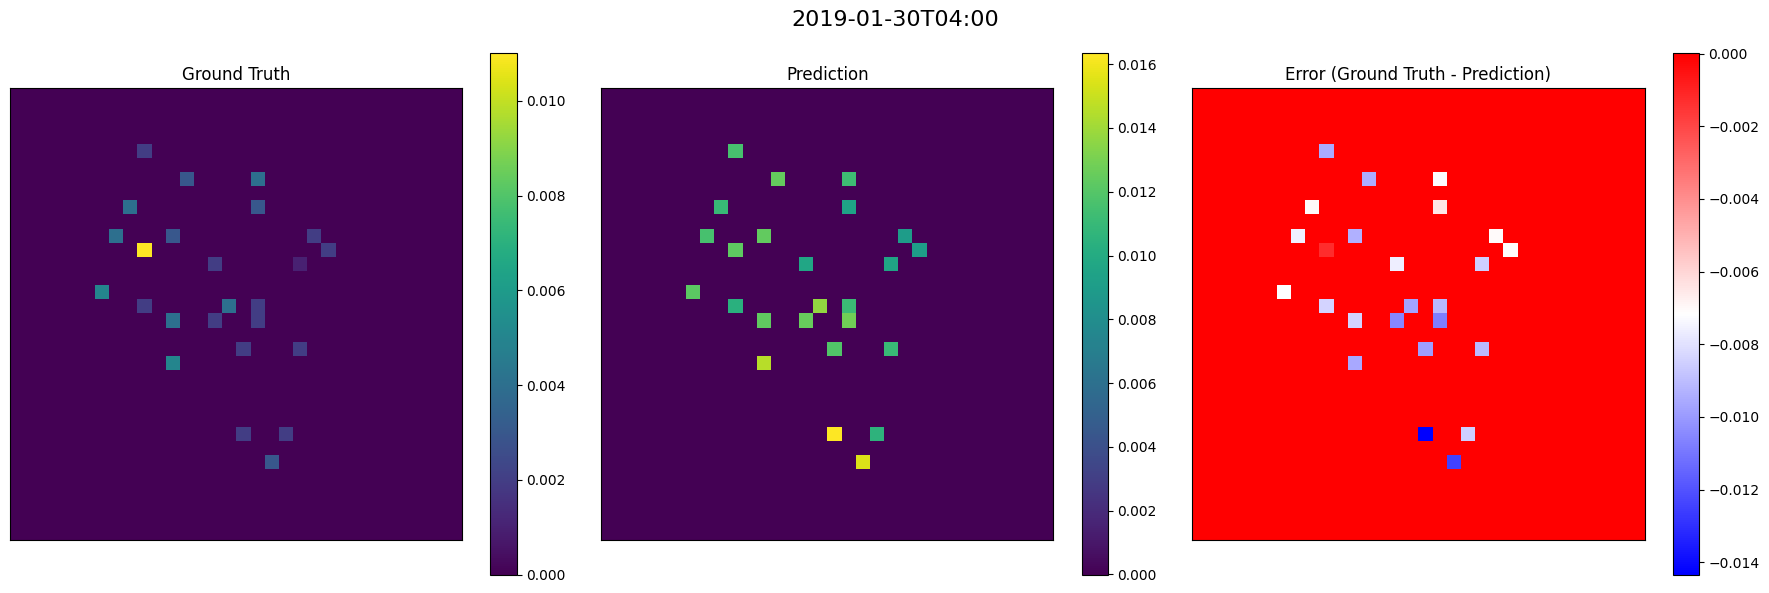

In [17]:
# 시각화 코드

# 이미 학습된 모델의 예측 결과와 실제 데이터를 가지고 있다고 가정합니다.
# Ozone_predict: 모델이 예측한 오존 농도 (shape: [744, 32, 32])
# label_grid_data: 실제 오존 농도 (shape: [744, 1, 32, 32, 1])

# 실제 데이터의 마지막 차원 제거 (차원 맞추기)
ground_truth = label_grid_data.reshape(-1, grid_size, grid_size)  # shape: [744, 32, 32]

# 에러 계산
error = ground_truth - Ozone_predict  # shape: [744, 32, 32]

# 시각화를 위한 함수 정의
def plot_ozone_maps(index):
    """
    특정 날짜와 시간에 대한 오존 농도의 실제값, 예측값, 에러를 시각화합니다.

    Parameters:
    - day_index (int): 0부터 30까지의 날짜 인덱스 (0은 1월 1일)
    - hour_index (int): 0부터 23까지의 시간 인덱스
    """
    # 데이터 추출
    gt = ground_truth[index]  # 실제 값
    pred = Ozone_predict[index]  # 예측 값
    err = error[index]  # 에러

    # 플롯 설정
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Ground Truth 시각화
    im1 = axes[0].imshow(gt, cmap='viridis', interpolation='nearest')
    axes[0].set_title('Ground Truth')
    plt.colorbar(im1, ax=axes[0])

    # Prediction 시각화
    im2 = axes[1].imshow(pred, cmap='viridis', interpolation='nearest')
    axes[1].set_title('Prediction')
    plt.colorbar(im2, ax=axes[1])

    # Error 시각화
    im3 = axes[2].imshow(err, cmap='bwr', interpolation='nearest')
    axes[2].set_title('Error (Ground Truth - Prediction)')
    plt.colorbar(im3, ax=axes[2])

    # 공통 설정
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

    data_date = time_stamp[index].astype(str)

    # 전체 제목 설정
    fig.suptitle(data_date, fontsize=16)
    plt.tight_layout()
    plt.show()

# 예시: 1월 1일 0시 데이터를 시각화
plot_ozone_maps(index=700)